# Query GFS Data from Thredds Server

What is a Thredds server?  
https://www.unidata.ucar.edu/software/tds/current/

In [1]:
from IPython.display import Image

## Task

We want to query forecasts for wind gusts for an area above the Mediterranean Sea:





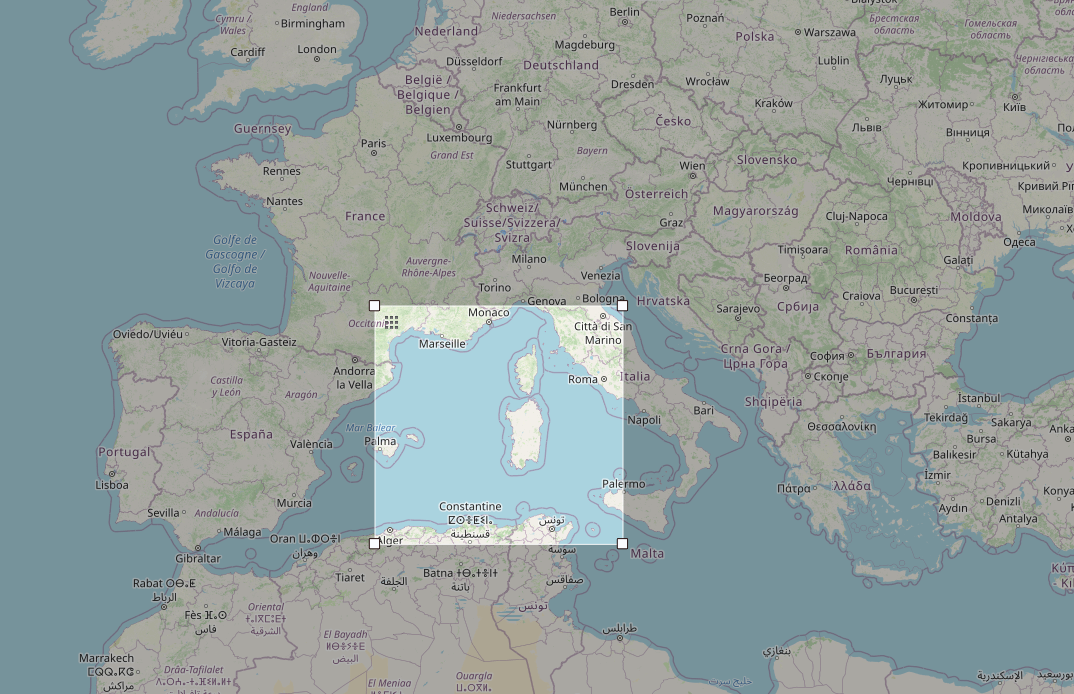

In [21]:
PATH = "/home/imke/Desktop/MariData/Data/shipWeatherRouting/img/"
image = Image(filename = PATH + "Mittelmeer_GFS.png", width=800, height=800)
image

In [3]:
from siphon.catalog import TDSCatalog

"""
    Siphon is a collection of Python utilities for downloading data from remote data services. 
    Much of Siphon’s current functionality focuses on access to data hosted on a THREDDS Data Server. 
    It also provides clients to a variety of simple web services.
    Link to documentation:https://unidata.github.io/siphon/latest/index.html
"""

# for autocompletion disable the autocompletion tool 'jedi'
%config Completer.use_jedi = False

In [4]:
"""
    Read a catalog from THREDDS Data Server
    First construct a TDSCatalog instance pointing to the dataset of interest, in this case TDS’ “Best” virtual
    dataset for the GFS global 0.25 degree collection of GRIB files. 
    This catalog contains a single dataset.
"""

best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
best_gfs.datasets

['Best GFS Quarter Degree Forecast Time Series']

In [5]:
# Pull out the dataset and call subset() to set up requesting a subset of the data.
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()

In [6]:
# Use the ncss object to create a new query object, which facilitates asking for data from the server.
query = ncss.query()

In [7]:
# Look at the ncss.variables object to see what variables are available from the dataset:
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_hybrid',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_p

### Create query
Construct a query asking for data corresponding to a latitude and longitude box where 
- 44 lat is the northern extent 
- 36 lat is the southern extent 
- 2 long is the western extent 
- 13 is the eastern extent   

(Note: longitude values are the longitude distance from the prime meridian.)

Request the data for the current time.   
This request will return all surface temperatures for points in the bounding box for a single time.  
(Note: the string representation of the query is a properly encoded query string)

In [8]:
from datetime import datetime

In [9]:
# Set extent and time
query.lonlat_box(north=44, south=36, west=2, east=13, ).time(datetime.utcnow())

# Set data format to be accepted, here netcdf4
query.accept('netcdf4')

# Set target variable
query.variables('Wind_speed_gust_surface','Geopotential_height_maximum_wind', 'Temperature_maximum_wind')

var=Wind_speed_gust_surface&var=Temperature_maximum_wind&var=Geopotential_height_maximum_wind&time=2021-02-25T11%3A50%3A44.435030&west=2&east=13&south=36&north=44&accept=netcdf4

Now, request data from the server using the created query.  
The NCSS class handles parsing this NetCDF data (using the netCDF4 module). If we print out the variable names, we see the requested variables, as well as a few others (more metadata information)

In [10]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

In [11]:
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

list(data)
lala = data.to_netcdf('out_1.nc')

Pull out the relevant variable

In [12]:
temp_3d = data['Wind_speed_gust_surface']
temp_3d

<xarray.DataArray 'Wind_speed_gust_surface' (time: 1, lat: 33, lon: 45)>
array([[[5.730689, 3.530689, ..., 2.730689, 4.030688],
        [3.230689, 7.230689, ..., 0.730688, 1.430689],
        ...,
        [2.030689, 2.830688, ..., 1.330688, 1.430689],
        [3.030689, 2.430688, ..., 0.730688, 1.030689]]], dtype=float32)
Coordinates:
    reftime  (time) datetime64[ns] ...
  * time     (time) datetime64[ns] 2021-02-25T12:00:00
  * lat      (lat) float32 44.0 43.75 43.5 43.25 43.0 ... 36.75 36.5 36.25 36.0
  * lon      (lon) float32 2.0 2.25 2.5 2.75 3.0 ... 12.0 12.25 12.5 12.75 13.0
Attributes:
    long_name:                      Wind speed (gust) @ Ground or water surface
    units:                          m/s
    abbreviation:                   GUST
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-2-22_L1
    Grib2_Parameter:                [ 0  2 22]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Momentum
    Grib2_Parameter_Name:           Wind speed (gust)
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water surface
    Grib2_Generating_Process_Type:  Forecast

Pull out latitude,longitude and time (which is the time, in hours since the forecast run). 

Print one of the variables to see some info on the data!

In [13]:
# Helper function for finding the proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError('No time variable found for ' + var.name)

In [14]:
# Lontitude and latitude
lat_1d = data['lat']
lon_1d = data['lon']

In [15]:
# Time
time_1d = find_time_var(temp_3d)
time_1d

<xarray.DataArray 'time' (time: 1)>
array(['2021-02-25T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    reftime  (time) datetime64[ns] 2021-02-25T06:00:00
  * time     (time) datetime64[ns] 2021-02-25T12:00:00
Attributes:
    standard_name:        time
    long_name:            GRIB forecast or observation time
    _CoordinateAxisType:  Time

## Prepare data for plotting
Import numpy to combine lat/longs (meshgrid) and remove one-dimensional entities from the arrays (squeeze).  
Use netCDF4's num2date to change the time since the model run to an actual date.

MetPy is a collection of tools in Python for reading, visualizing, and performing calculations with weather data.
Link to documentation of MetPy: https://unidata.github.io/MetPy/latest/index.html
The unit registry encapsulates all of the available units, as well as any pertinent settings. 
The registry also understands unit prefixes and suffixes; this allows the registry to understand 'kilometer' and
'meters' in addition to the base 'meter' unit.
For example, with units attached, it is possible to perform mathematical operations, resulting in the proper units
Link to metpy.units: https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html#working-with-units

In [16]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units

In [17]:
# Reduce the dimensions of the data and get it as array with units

# convert xarray to numpy array with units attached
temp_2d_1 = temp_3d.metpy.unit_array

# remove the unit dimension from the array as the unit is attached
temp_2d = temp_2d_1.squeeze()

print('array before dimension reduction:',temp_2d_1.shape, 'and after:', temp_2d.shape)

array before dimension reduction: (1, 33, 45) and after: (33, 45)


In [18]:
# Create meshgrid by combining latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

## Plotting the data

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

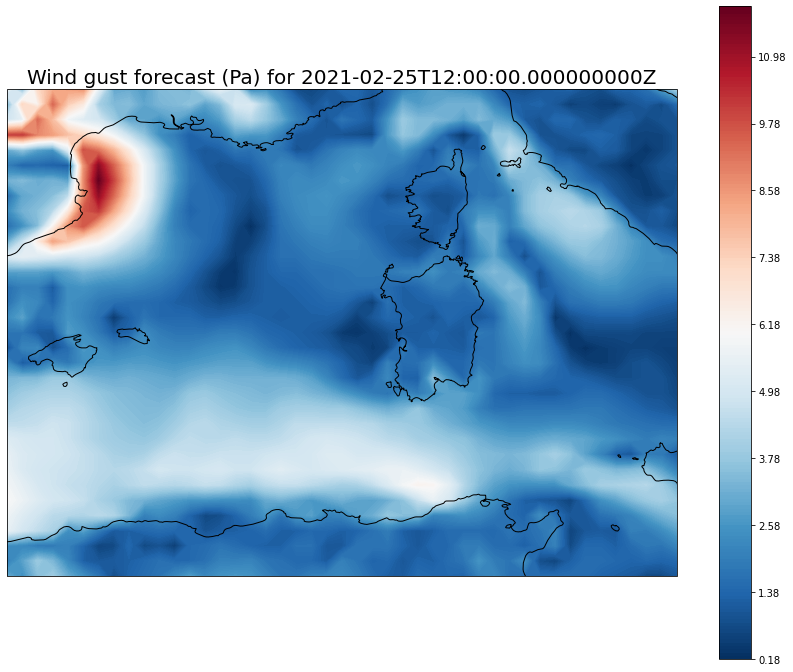

In [20]:
# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([44, 36, 13, 2])
ax.coastlines()
# Retrieve the state boundaries using cFeature and add to plot
ax.add_feature(cfeature.LAND, edgecolor='gray')

# Contour wind speed at each lat/long
contours = ax.contourf(lon_2d, lat_2d, temp_2d.to('meter / second'), 200, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r')

# Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(f'Wind gust forecast (Pa) for {time_1d[0].values}Z', fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), linestyle='none', marker='o',
        color='black', markersize=0.5, alpha=0.0, transform=ccrs.PlateCarree());
